In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from models.dit import DiT
from models import *
from tqdm import tqdm
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc
)

c:\Users\Pro\anaconda3\envs\DiT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### 테스트 데이터셋 클래스 정의

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path, header=None)

        label_map = {label: idx for idx, label in enumerate(df.iloc[:, 0].unique())}
        df.iloc[:, 0] = df.iloc[:, 0].map(label_map)

        self.X = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(df.iloc[:, 0].values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#### 데이터 로드

In [20]:
csv_path = "C:/Users/Pro/Desktop/AnomalyDiT-main/AnomalyDiT-main/Dataset/ECG_Test_with_anomaly.csv"
label_path = "C:/Users/Pro/Desktop/AnomalyDiT-main/AnomalyDiT-main/Dataset/ECG_Anomaly_PointLabels.npy"

test_dataset = TimeSeriesDataset(csv_path)
test_loader = DataLoader(test_dataset, batch_size=64)

point_labels = np.load(label_path).flatten()  # 시점별 이상 라벨

#### 모델 불러오기

In [21]:
model = DiT(input_size=750, patch_size=5, in_channels=1, num_classes=42).to(device)
model.load_state_dict(torch.load("dit_ts_model.pt", map_location=device))
model.eval()

C:\Users\Pro\AppData\Local\Temp\ipykernel_24812\1507463972.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dit_ts_model.pt", map_locati

DiT(
  (label_emb): Embedding(42, 512)
  (x_embedder): PatchEmbed(
    (proj): Conv1d(1, 512, kernel_size=(5,), stride=(5,))
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (y_embedder): ConditionEmbedder(
    (proj): PatchEmbed(
      (proj): Conv1d(1, 512, kernel_size=(5,), stride=(5,))
    )
    (pool): AdaptiveAvgPool1d(output_size=1)
    (linear): Linear(in_features=512, out_features=512, bias=True)
  )
  (blocks): ModuleList(
    (0-27): 28 x DiTBlock(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dro

#### 예측값 생성

In [22]:
pred_scores = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating", unit="batch"):
        x = x.to(device)
        t = torch.zeros(x.size(0), dtype=torch.long).to(device)
        out = model(x, t, y.to(device))  # (B, 2, 750)
        mean_pred = out[:, 0, :]  # 평균 채널만 사용
        pred_scores.append(mean_pred.cpu())

pred_scores = torch.cat(pred_scores, dim=0).numpy().flatten()

Evaluating: 100%|██████████| 62/62 [03:11<00:00,  3.08s/batch]


#### Precision-Recall 기반 threshold 탐색

In [23]:
precision, recall, thresholds_pr = precision_recall_curve(point_labels, pred_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_idx]

#### ROC AUC 계산

In [24]:
fpr, tpr, thresholds_roc = roc_curve(point_labels, pred_scores)
roc_auc = auc(fpr, tpr)

#### 최종 이진 예측

In [25]:
pred_binary = (pred_scores > best_threshold).astype(int)

In [26]:
print(f"▶ Best Threshold (by F1): {best_threshold:.4f}")
print(f"▶ Best F1 Score: {f1_scores[best_idx]:.4f}")
print(f"▶ Precision at best: {precision[best_idx]:.4f}")
print(f"▶ Recall at best: {recall[best_idx]:.4f}")
print(f"▶ ROC AUC Score: {roc_auc:.4f}")

▶ Best Threshold (by F1): 0.5436
▶ Best F1 Score: 0.5429
▶ Precision at best: 0.5072
▶ Recall at best: 0.5841
▶ ROC AUC Score: 0.9160


#### F1-score vs Threshold

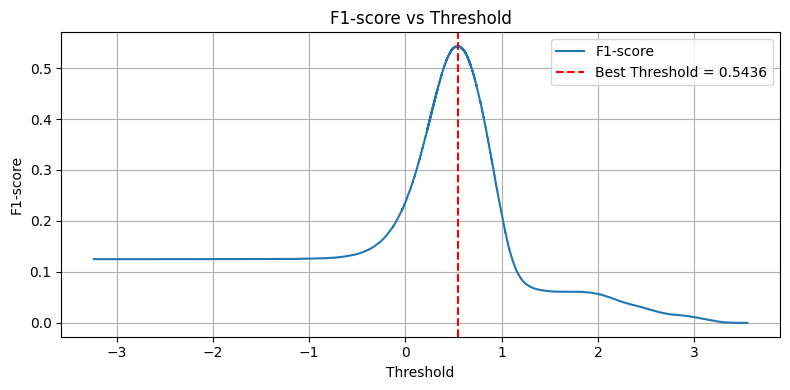

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds_pr, f1_scores[1:], label="F1-score")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.4f}")
plt.title("F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Precision-Recall Curve

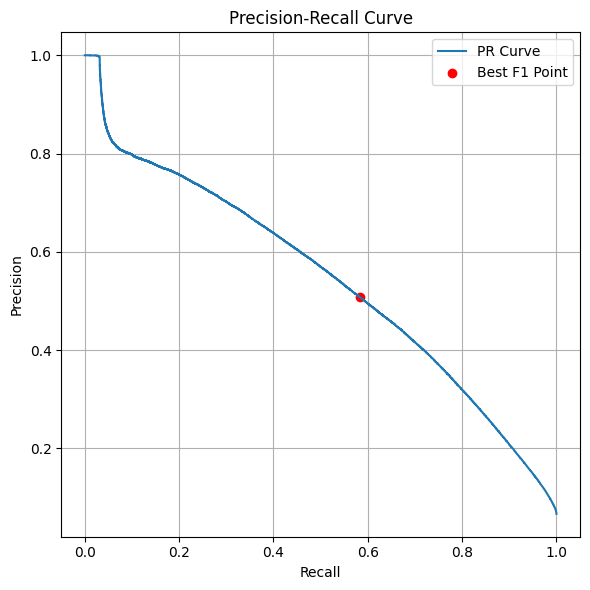

In [29]:
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label='PR Curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label='Best F1 Point')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### ROC Curve

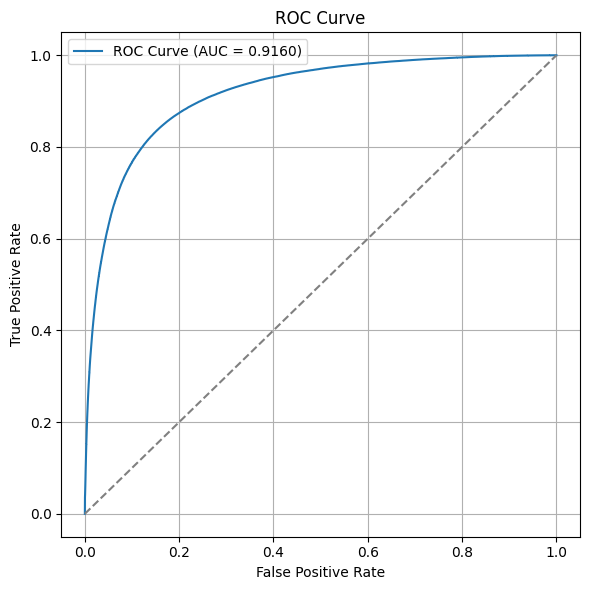

In [30]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 성능 출력

In [16]:
print(f"🔍 F1-score 기준 최적 threshold: {best_threshold:.4f}")
print(classification_report(point_labels, pred_binary, target_names=["정상", "이상"]))

🔍 F1-score 기준 최적 threshold: 0.5436
              precision    recall  f1-score   support

          정상       0.97      0.96      0.96   2751000
          이상       0.51      0.58      0.54    196500

    accuracy                           0.93   2947500
   macro avg       0.74      0.77      0.75   2947500
weighted avg       0.94      0.93      0.94   2947500



#### 예측 점수 시각화

파란색 선: 모델이 출력한 각 시점의 예측 score (pred_scores)

주황색 영역: 실제 이상이 존재하는 시점 (point_labels)

빨간 점선: F1-score 기준으로 선택된 threshold (0.5436)

C:\Users\Pro\AppData\Local\Temp\ipykernel_24812\1853647363.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\Pro\anaconda3\envs\DiT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


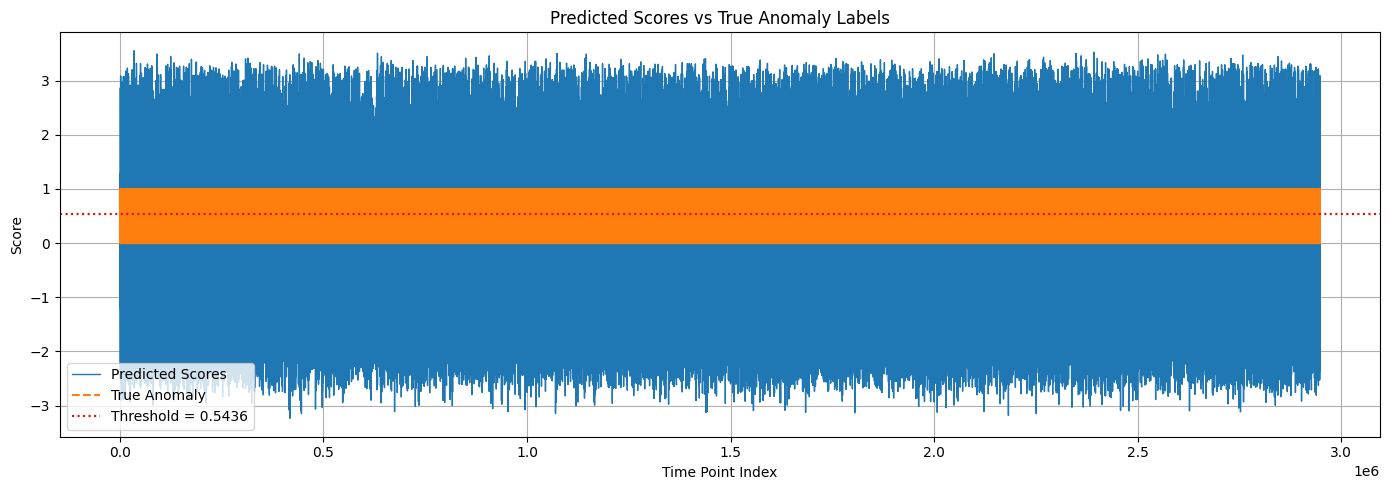

In [31]:
plt.figure(figsize=(14, 5))
plt.plot(pred_scores, label="Predicted Scores", linewidth=1)
plt.plot(point_labels * 1.0, label="True Anomaly", linestyle='--')  # ✔ 스케일 조절
plt.axhline(best_threshold, color='red', linestyle=':', label=f"Threshold = {best_threshold:.4f}")
plt.title("Predicted Scores vs True Anomaly Labels")
plt.xlabel("Time Point Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

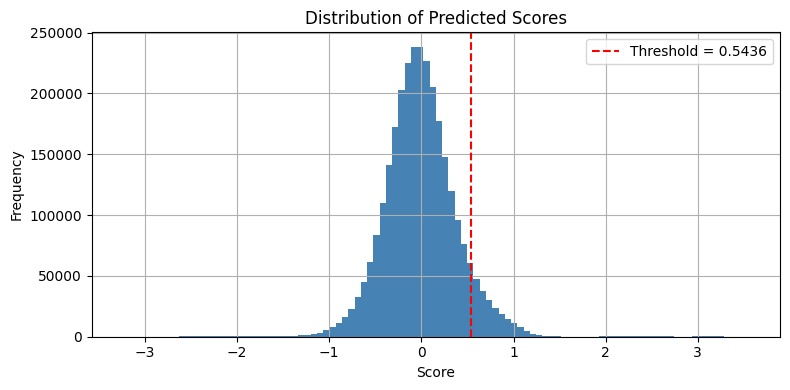

In [32]:
plt.figure(figsize=(8, 4))
plt.hist(pred_scores, bins=100, color='steelblue')
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Threshold = {best_threshold:.4f}")
plt.title("Distribution of Predicted Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# 시계열 데이터 추출
X = test_dataset.X.numpy()         # shape: (N, 1, T)
test_series = X[:, 0, :]           # shape: (N, T)

# point_labels와 pred_scores reshape
point_labels = point_labels.reshape(test_series.shape)
pred_scores = pred_scores.reshape(test_series.shape)

test_labels = test_dataset.y.numpy()

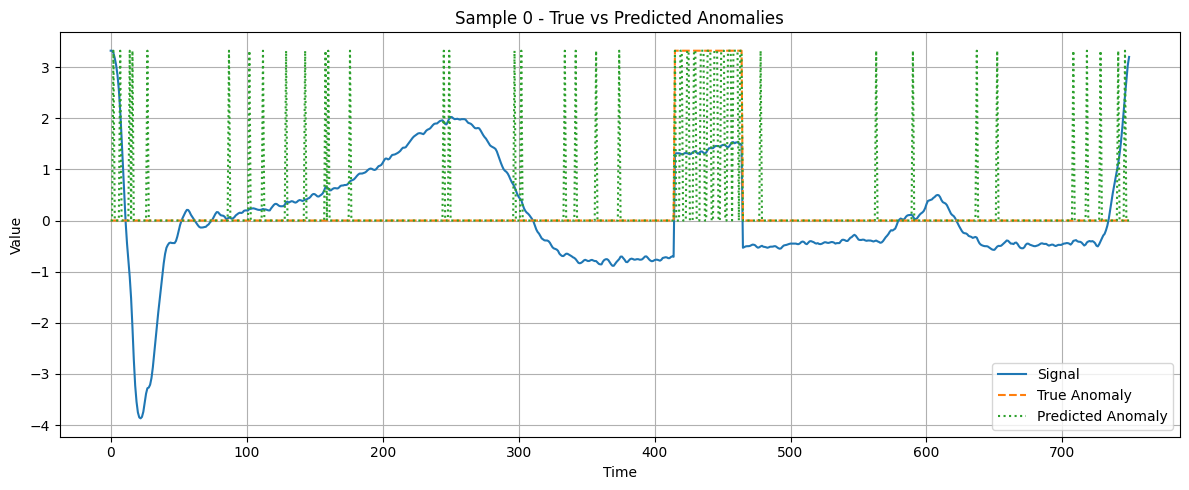

In [38]:
i = 0
signal = test_series[i]
true_anom = point_labels[i]
pred_score = pred_scores[i]
pred_anom = (pred_score > best_threshold).astype(int)

plt.figure(figsize=(12, 5))
plt.plot(signal, label="Signal")
plt.plot(true_anom * np.max(signal), label="True Anomaly", linestyle='--')
plt.plot(pred_anom * np.max(signal), label="Predicted Anomaly", linestyle=':')
plt.title(f"Sample {i} - True vs Predicted Anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

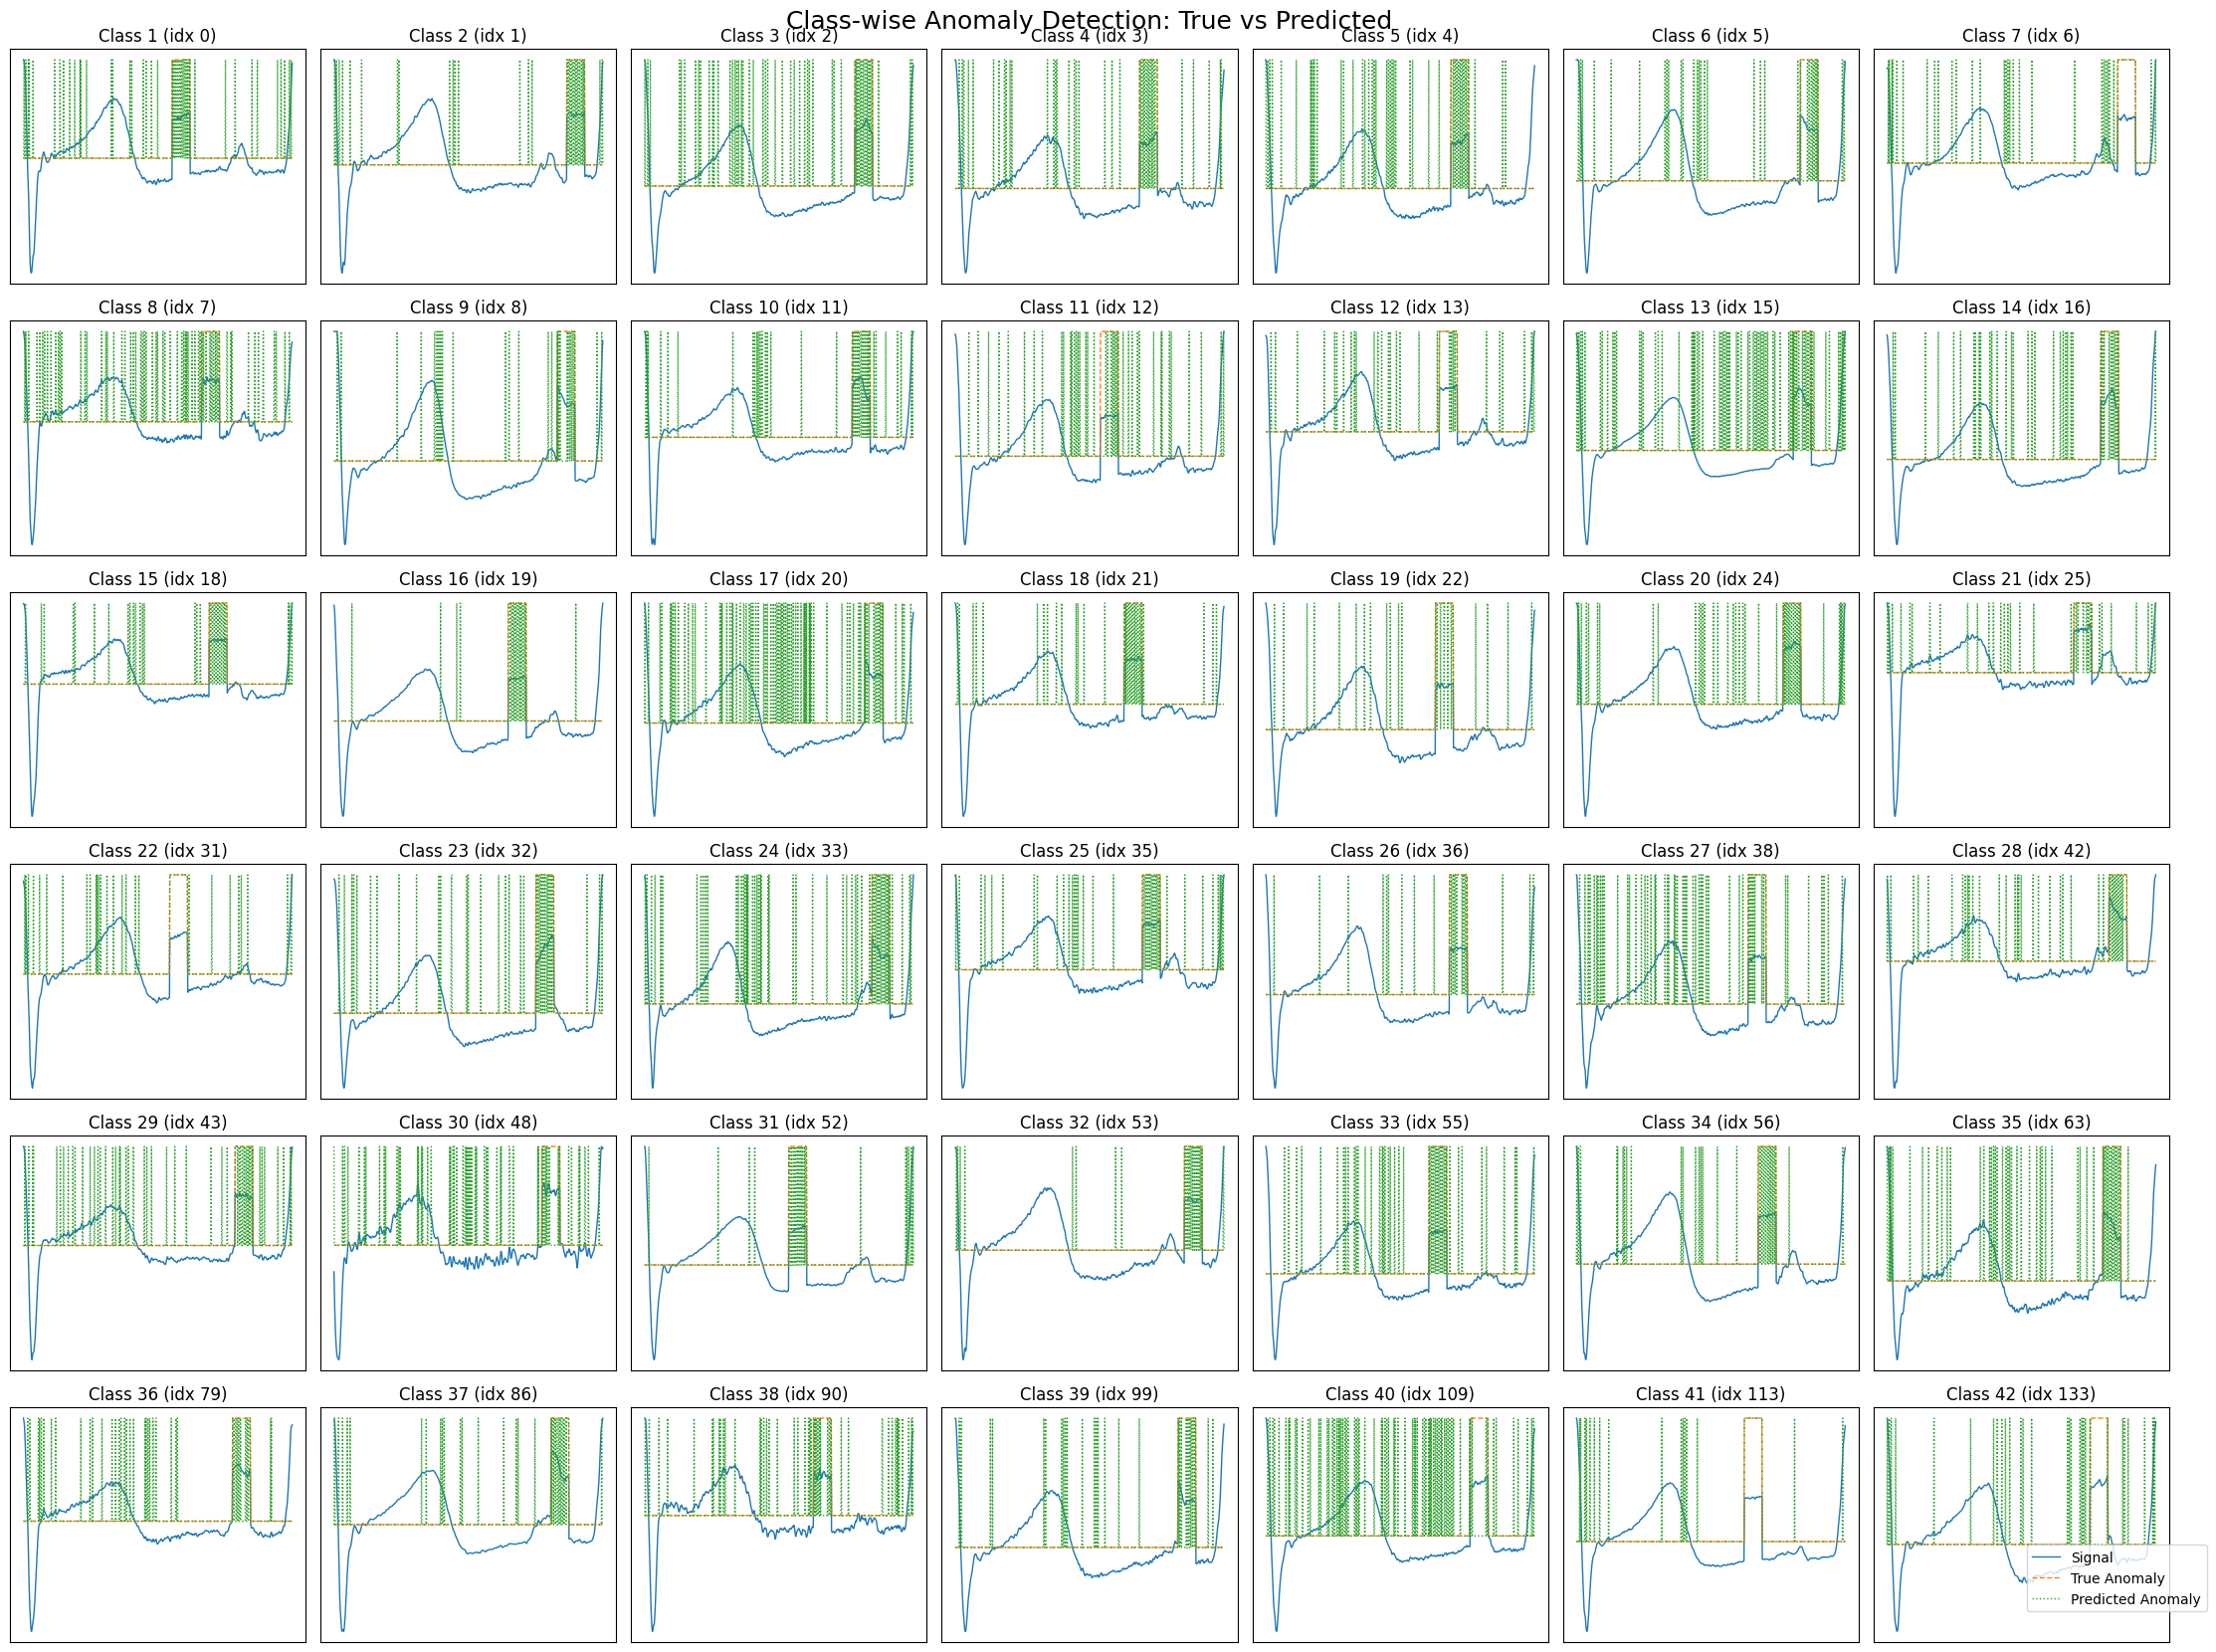

In [39]:
# 고유 클래스 목록
unique_classes = sorted(np.unique(test_labels))

# subplot 시각화
n_rows, n_cols = 6, 7  # 42개 클래스 기준
plt.figure(figsize=(22, 18))

for idx, cls in enumerate(unique_classes):
    # 해당 클래스의 첫 번째 시계열 index 찾기
    sample_idx = np.where(test_labels == cls)[0][0]
    
    signal = test_series[sample_idx]
    true_anom = point_labels[sample_idx]
    pred_score = pred_scores[sample_idx]
    pred_anom = (pred_score > best_threshold).astype(int)

    plt.subplot(n_rows, n_cols, idx + 1)
    plt.plot(signal, label='Signal', linewidth=1)
    plt.plot(true_anom * np.max(signal), '--', label='True Anomaly', linewidth=1)
    plt.plot(pred_anom * np.max(signal), ':', label='Predicted Anomaly', linewidth=1)
    plt.title(f"Class {cls+1} (idx {sample_idx})")
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)

# 전체 제목 및 범례
plt.suptitle("Class-wise Anomaly Detection: True vs Predicted", fontsize=18, y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0.1))
plt.show()

## 이전

In [5]:
train = pd.read_csv('C:/Users/Pro/Desktop/AnomalyDiT-main/AnomalyDiT-main/Dataset/ECG_Train_with_anomaly.csv', sep='\t', index_col=False, header=None)
test = pd.read_csv('C:/Users/Pro/Desktop/AnomalyDiT-main/AnomalyDiT-main/Dataset/ECG_Test_with_anomaly.csv', sep='\t', index_col=None, header=None)

In [6]:
train = torch.Tensor(train.drop(columns=0).to_numpy()).unsqueeze(1)
test = torch.Tensor(test.drop(columns=0).to_numpy()).unsqueeze(1)

In [7]:
test.shape

torch.Size([3930, 1, 0])

In [8]:
net = DiT(input_size=750,
        patch_size=5,
        in_channels=1,
        hidden_size=300,
        depth=28,
        num_heads=10,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        learn_sigma=False,)

In [9]:
x = torch.randn(4,1,750)
y = test[:4]
t = torch.randint(low=0, high=10000, size=(4,))